# Anomaly detection
In this notebook we will use a multivariate normal model to detect points that display an anomalous behaviour, i.e. points which have a low probability. Let's first visualize the dataset, which is stored in a Matlab-formatted file and consists of 307 examples and 2 features.

In [1]:
#import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.stats import multivariate_normal


#load data
data = loadmat("ex8data1.mat")
X = data['X']

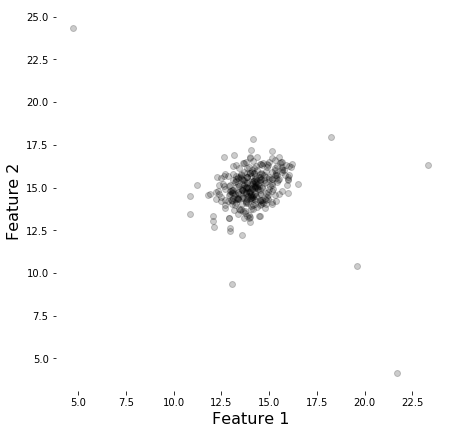

In [37]:
#plot data
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(X[:, 0], X[:, 1], c='black', alpha=0.2)
ax.set_xlabel("Feature 1", fontsize=16)
ax.set_ylabel("Feature 2", fontsize=16)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.show()

We can see most the data are grouped together while a few data points a further away from the center of the cluster. To automatically classify some data points as outliers, we first need to model the data according to a **multivariate normal distribution**. To do so, we need to calculate for each feature $i$ the mean $\mu_i$ and the variance $\sigma_i^2$.

In [19]:
#function to estimate parameters of a multivariate normal distribution based on the data
def estimate(X):
    """Calculates estimates of the means mu and variance sigma2 of the data X which contains several features."""
    mu = np.mean(X, axis=0)
    sigma2 = np.std(X, axis=0) **2
    return mu, sigma2

mu, sigma2 = estimate(X)
print("The means of the multivariate normal model are", mu)
print("The variances of the multivariate normal model are", sigma2)

The means of the multivariate normal model are [14.11222578 14.99771051]
The variances of the multivariate normal model are [1.83263141 1.70974533]


Next, we are going to define the model with these parameters and show the contour of that correspond to probabilities associated with model.

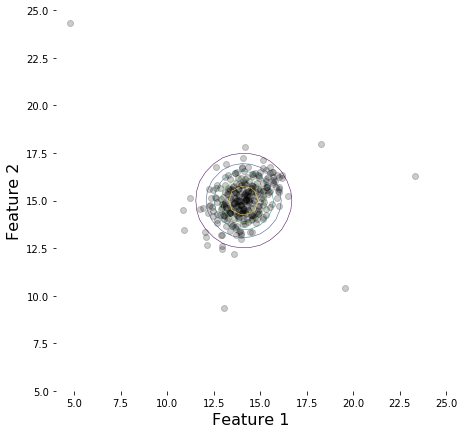

In [38]:
#generate grid for plotting the contours
X1 = np.linspace(0, 35, 71)
X1, X2 = np.meshgrid(X1, X1)
pos = np.empty(X1.shape +(2,))
pos[:, :, 0] = X1
pos[:, :, 1] = X2

#define the multivariate normal model
rv = multivariate_normal(mu, sigma2)

#plot contour with data
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlabel("Feature 1", fontsize=16)
ax.set_ylabel("Feature 2", fontsize=16)
ax.scatter(X[:, 0], X[:, 1], c='black', alpha=0.2)
ax.contour(X1, X2, rv.pdf(pos), linewidths=0.5)
ax.set_xlim(4, 25)
ax.set_ylim(5, 25)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.show()

The most external contour represents probabilities of 0.01. Let's set a threshold probability of 0.001 to define outliers, that is to say a point will be classified as an outlier if its probability based on the multivariate normal model is below 0.01.

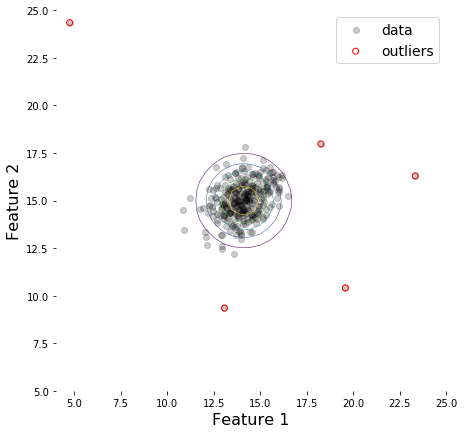

In [40]:
#get outliers at p <0.001
p = rv.pdf(X)
outliers = np.where(p < 0.001)

#plot outliers with contour and data
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlabel("Feature 1", fontsize=16)
ax.set_ylabel("Feature 2", fontsize=16)
ax.scatter(X[:, 0], X[:, 1], c='black', alpha=0.2, label='data')
ax.contour(X1, X2, rv.pdf(pos), linewidths=0.5)
ax.scatter(X[outliers, 0], X[outliers, 1], facecolor='none', edgecolor='red', label='outliers')
ax.set_xlim(4, 25)
ax.set_ylim(5, 25)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.legend(fontsize=14)
plt.show()

# Recommender systems
We will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings. This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u=943$ users and $n_m=1643$ movies.

## Movie ratings dataset
First, we load the dataset *ex8_movies.mat*, providing the variables Y and R. The matrix Y has shape $n_m \times n_u$ and stores the ratings $y^{(i, j)}$. The matrix R is a binary-value indicator matrix, where $R(i, j)=1$ if user $j$ gave a rating to movie $i$, and 0 otherwise. The objective is to predict movie ratings for the movies that users have not yet rating, that is, entries with $R(i, j)=0$. This allows to recomment the movies with the highest predicted rating. We can also visualize the ratings of all movies by all users in the form of a heatmap.

We will also work with matrics X and Theta. The i-th row of X corresponds to the feature vector $x^{(i)}$ for the i-th movie and the j-th row of Theta corresponds to one parameter vector $\theta^{(j)}$ for the j-th user. Both $x^{(i)}$ and $\theta^{(j)}$ are n-dimensional vectors.

Average rating for movie 96 (Terminator 2: Judgment Day) : 4.01


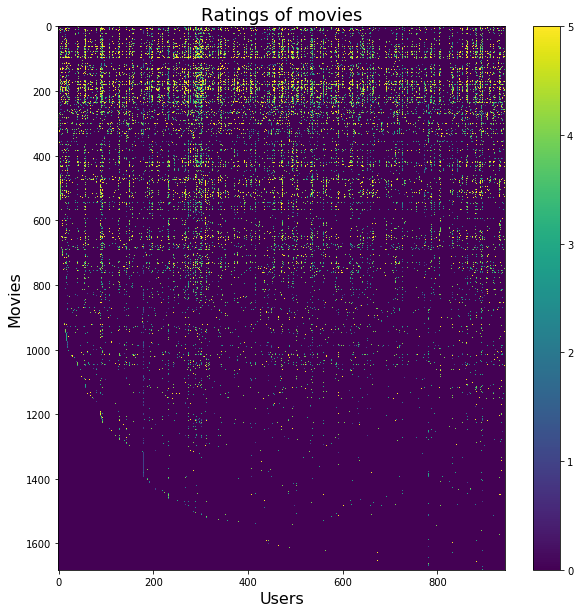

In [9]:
movies = loadmat("ex8_movies.mat")
Y = movies['Y']
R = movies['R']

#average rating for movie 96
ratings = Y[95, R[95]==1]
avg_rat = np.mean(ratings)
print("Average rating for movie 96 (Terminator 2: Judgment Day) : {:.2f}".format(avg_rat))

#heatmap of ratings
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(Y, interpolation='nearest')
ax.set_aspect('auto')
ax.set_xlabel('Users', fontsize=16)
ax.set_ylabel('Movies', fontsize=16)
ax.set_title('Ratings of movies', fontsize=18)
ax.figure.colorbar(im, ax=ax)
plt.show()

## Collaborative filtering learning algorithm

The collaborative filtering algorithm in the setting of movie recommendations considers a set of n-dimensional parameter vector $x^{(1)}, ..., x^{n_m}$ and $\theta^{(1)}, ..., \theta^{n_u}$ where the model predicts the rating for movie i by user j as $y^{(i,j)} = (\theta^{(j)})^T x{(i)}$. Given a dataset that consists of ratings produced by some users on some movies, we want to learn the parameter vectors $x^{(1)}, ..., x^{n_m}$ and $\theta^{(1)}, ..., \theta^{n_u}$ that minimize the mean squared error.

The regularized cost function for collaborative filtering is:

$$J(x^{(1)},...,x^{n_m},\theta^{(1)},...,\theta^{n_u}=\frac{1}{2}\sum\limits_{(i,j):r(i,j)=1}((\theta^{(j)})^T x^{(i)}-y^{(i,j)})^2 +(\frac{\lambda}{2}\sum\limits_{j=1}^{n_u}\sum\limits_{k=1}^n(\theta_k^{(j)})^2+(\frac{\lambda}{2}\sum\limits_{i=1}^{n_m}\sum\limits_{k=1}^n(x_k^{(i)})^2$$

and the regularized gradient is:

$$\frac{\partial J}{\partial x_k^{(i)}} = \sum\limits_{j:r(i,j)=1}((\theta^{(j)})^T x^{(i)}-y^{(i,j)})\theta_k^{(j)} + \lambda x_k^{(i)}$$

$$\frac{\partial J}{\partial \theta_k^{(j)}} = \sum\limits_{j:r(i,j)=1}((\theta^{(j)})^T x^{(i)}-y^{(i,j)})x_k^{(i)} + \lambda \theta_k^{(j)}$$